# 台灣境內COVID-19確診及時資料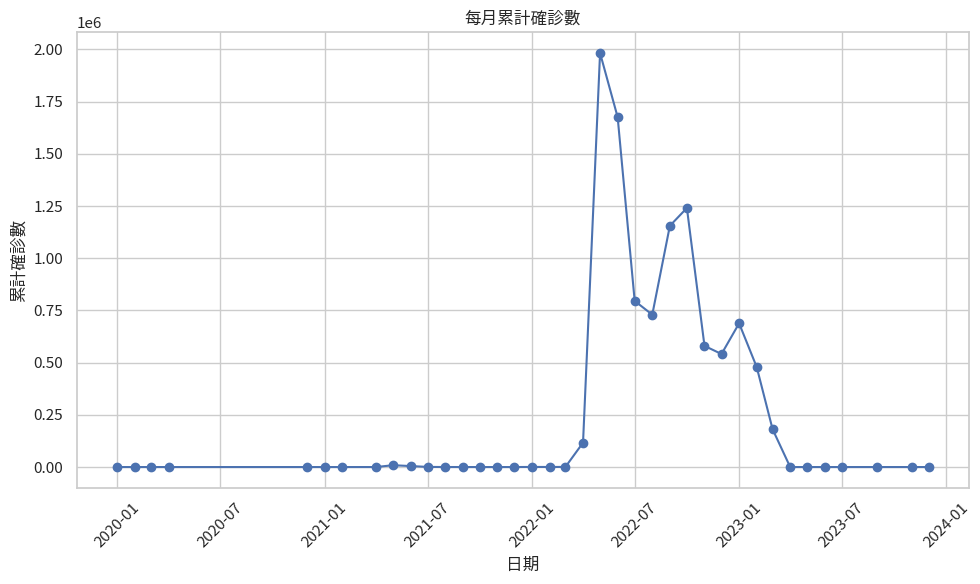

In [ ]:
!pip install facets-overview

In [ ]:
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
from IPython.core.display import display, HTML
import base64

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from datetime import datetime
import requests
import json

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 改style要在改font之前
# plt.style.use('seaborn')

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# Load Data

In [ ]:
data = {'lang':'tw','type':'2'}
req = requests.get("https://od.cdc.gov.tw/eic/Age_County_Gender_day_19Cov.json", params=data, verify=False)
if req.status_code == 200:
    data_Str = req.content.decode('utf-8')
    # str => json
    tmp = json.loads(data_Str)
    f = open("data.json",'wb')
    # json => str
    data_Json = json.dumps(tmp,indent=4,ensure_ascii=False).encode('utf8')
    f.write(data_Json)
    f.close()

# EDA

In [ ]:
df = pd.DataFrame(tmp)

df # 2209745 rows × 8 columns
# 第一筆資料 發病日 2020/01/20
# 最後一筆資料 發病日 2023/12/26

In [ ]:
# 生成統計信息的 proto
proto_combined = GenericFeatureStatisticsGenerator().ProtoFromDataFrames([{'name': 'Combined Data', 'table': df}])
protostr_combined = base64.b64encode(proto_combined.SerializeToString()).decode("utf-8")

# 創建 HTML 内容
html_content_combined = f'''
    <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
    <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/master/facets-dist/facets-jupyter.html">
    <facets-overview id="elem_combined"></facets-overview>
    <script>document.querySelector("#elem_combined").protoInput = "{protostr_combined}"</script>
'''
# 顯示 Facets Dive
display(HTML(html_content_combined))

# Processing Data

In [ ]:
categorical_columns = ['縣市' ,'鄉鎮', '性別', '是否為境外移入' ,'年齡層']

for column in categorical_columns:
    print(f"Unique values in {column}: {df[column].unique()}")

In [ ]:
# 刪除該欄位
df.drop(columns=['確定病名'], inplace=True)

# 刪除 是 '境外移入' 的資料
is_overseas_import = df['是否為境外移入'] == '是'
df = df[~is_overseas_import]

# 該欄位轉換為整數型態
df['確定病例數'] = df['確定病例數'].astype(int)

df # 2197057 rows × 7 columns

# 全台每月確診數

In [ ]:
df['發病日'] = pd.to_datetime(df['發病日'])
monthly_cases = df.groupby(df['發病日'].dt.to_period('M')).sum()[['確定病例數']]

plt.figure(figsize=(10, 6))
plt.plot(monthly_cases.index.to_timestamp(), monthly_cases['確定病例數'], marker='o', linestyle='-')
plt.title('每月累計確診數')
plt.xlabel('日期')
plt.ylabel('累計確診數')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

monthly_cases.to_csv('tw_monthly_cases.csv', header=True, encoding='utf-8-sig')



2022年4月至6月，確診病例數大幅增加，達到高峰

2022年7月至2023年7月：疫情逐漸得到控制，途中雖有反彈回升，但隨後又立即下降，確診病例數呈現下降趨勢

2023年8月至2023年12月：疫情保持相對穩定，確診病例數保持在較低水平


In [ ]:
print("每月確診累積病例數：")
print(monthly_cases)

# 六都每月確診數

In [ ]:
cityName = ['台北市', '新北市', '桃園市', '台中市', '台南市', '高雄市']

for city in cityName:
    city_data = df[df['縣市'] == city]
    city_cases = city_data.groupby('發病日').size().to_frame('確診數')
    monthly_cases = city_cases.resample('M').sum()

    plt.figure(figsize=(10, 6))
    plt.plot(monthly_cases.index, monthly_cases['確診數'], marker='o', linestyle='-')
    plt.title(f'{city}每月確診數')
    plt.xlabel('日期')
    plt.ylabel('確診數')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

六都的確診數曲線在2022年4月至6月，確診病例數都大幅增加，結合全台每月確診數圖表觀察，可得知在這時間段，全台和六都的疫情都非常嚴重

# 各縣市累計確診數

In [ ]:
city_cases = df.groupby('縣市').sum()[['確定病例數']]

city_cases.plot(kind='barh', figsize=(10, 10))
plt.xlabel('累計確診數')
plt.ylabel('縣市')
plt.title('各縣市累計確診數')
plt.show()

city_cases.to_csv('tw_city_cases.csv', header=True, encoding='utf-8-sig')

1e6單位等於一百萬

從圖表得知累積病例數最高的縣市為：

新北市，超過200萬筆

台中市，125萬筆左右

高雄市跟桃園市，112.5萬筆

台北市，100萬筆左右

# 累積確診數最高的鄉鎮

鄉鎮過多，故只取前25高的鄉鎮作圖呈現

In [ ]:
town_cases = df.groupby('鄉鎮').sum()[['確定病例數']]
top_25_towns = town_cases.nlargest(25, '確定病例數')

plt.figure(figsize=(12, 6))
top_25_towns.plot(kind='bar', color='skyblue')
plt.title('前 20 高鄉鎮的累計確診數')
plt.xlabel('鄉鎮')
plt.ylabel('累計確診數')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

top_25_towns.to_csv('tw_top_25_towns.csv', header=True, encoding='utf-8-sig')

前五高分別為：板橋區，東區，中和區，桃園區，新莊區

# 確診者性別比例

Unique values in 性別: ['F' 'M' 'X' 'U']

男性（M）、女性（F）、不指明或其他性別認同（X）、未知（U）

In [ ]:
gender_mapping = {'M': '男性', 'F': '女性', 'X': '不指明或其他性别認同', 'U': '未知'}
df['性別'] = df['性別'].map(gender_mapping)
gender_counts = df['性別'].value_counts()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
gender_counts.plot(kind='bar', color=['blue', 'pink', 'gray', 'lightgray'])
plt.title('性别分布')
plt.xlabel('性别')
plt.ylabel('計數')

plt.subplot(1, 2, 2)
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['blue', 'pink', 'gray', 'lightgray'])
plt.title('性别分布')

plt.tight_layout()
plt.show()

gender_counts = df['性別'].value_counts()
print(f"性別計數：{gender_counts}")

女性111.5萬，男性108萬，另外兩類計數與比率過少，上圖不易觀察，因此下方額外作圖

In [ ]:
other_gender_counts = df['性別'].value_counts().loc['不指明或其他性别認同']
unknown_gender_counts = df['性別'].value_counts().loc['未知']

plt.figure(figsize=(8, 6))
plt.bar(['不指明或其他性别認同', '未知'], [other_gender_counts, unknown_gender_counts], color=['gray', 'lightgray'])
plt.title('不同性别的计数')
plt.xlabel('性别')
plt.ylabel('计数')
plt.show()

未知有1600筆資料，不指明或其他則是接近200

# 確診者年齡分布

Unique values in 年齡層: ['55-59' '40-44' '65-69' '50-54' '70+' '20-24' '60-64' '30-34' '45-49'
 '10-14' '35-39' '25-29' '4' '15-19' '5-9' '3' '1' '0' '2']

In [ ]:
df['年齡層'] = df['年齡層'].replace({'0': '0-4', '1': '0-4', '2': '0-4', '3': '0-4', '4': '0-4'})

categorical_columns = ['年齡層']

for column in categorical_columns:
    print(f"Unique values in {column}: {df[column].unique()}")

In [ ]:
age_counts = df['年齡層'].value_counts()

plt.figure(figsize=(10, 6))
age_counts.plot(kind='bar', color='skyblue')
plt.title('年齡段確診病例數')
plt.xlabel('年齡段')
plt.ylabel('確診病例數')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

0-4確診病例數最高，其次為70+，25-29，40-44

In [ ]:
print(age_counts)

# 六都確診者年齡分布

In [ ]:
for city in cityName:
    city_data = df[df['縣市'] == city]
    age_counts = city_data['年齡層'].value_counts()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=age_counts.index, y=age_counts.values)
    plt.title(f'{city} 不同年齡段的確診病例數')
    plt.xlabel('年離段')
    plt.ylabel('確診病例數')
    plt.xticks(rotation=45)
    plt.legend([city])
    plt.show()

從圖表得知六都的確診年齡層第一高都是0-4歲的幼童，我們應針對幼童的防疫政策做更進一步的改善，像是採取針對性的防控措施或是優先施打疫苗等方案

此外也可得知雙北和台南的確診者都偏向幼童、老年、中年

桃園和台中偏向幼童、成年、壯年

這或許與該縣市的人口組成有關



